# Running Circuits on Hardware

This tutorial shows how a quantum circuit can be run on actual quantum hardware.

## Import all Necessary Libraries

In [ ]:
from NoisyCircuits.QuantumCircuit import QuantumCircuit as nqc
from NoisyCircuits.utils.GetNoiseModel import GetNoiseModel
from NoisyCircuits.RunOnHardware import RunOnHardware
import os
import json
import matplotlib.pyplot as plt

2025-11-24 13:00:40,331	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Define the Necessary Parameters

In [ ]:
token = json.load(open(os.path.join(os.path.expanduser("~"), "ibm_api.json"), "r"))["apikey"] # Replace with your IBM Quantum API token
backend_name = "ibm_fez"
shots = 1024
verbose = False
jsonize = True
num_qubits = 2
num_trajectories = 100
qpu = "heron" # Only possible option for IBM backends at the moment
num_cores = 4
sim_backend = "pennylane" # Choose between "pennylane", "qiskit" and "qulacs"

## Get the Noise Model

In [3]:
noise_model = GetNoiseModel(
    token=token,
    backend_name=backend_name
).get_noise_model()

qiskit_runtime_service._discover_account:WARNING:2025-11-24 13:00:47,297: Loading account with the given token. A saved account will not be used.
qiskit_runtime_service.__init__:WARNING:2025-11-24 13:00:50,681: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: Open_Sys. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-11-24 13:00:50,684: Using instance: Open_Sys, plan: open
qiskit_runtime_service.backends:WARNING:2025-11-24 13:00:51,053: Using instance: Open_Sys, plan: open


## Build the Quantum Circuit

For this tutorial, we stick to the simple Bell State circuit

In [ ]:
circuit = nqc(num_qubits=num_qubits, 
         noise_model=noise_model, 
         num_cores=num_cores,
         backend_qpu_type=qpu, 
         num_trajectories=num_trajectories, 
         sim_backend=sim_backend,
         jsonize=jsonize,
         verbose=verbose)

2025-11-24 13:01:03,524	INFO worker.py:2012 -- Started a local Ray instance.
/Users/adam-ukj7r05xnu2fywx/miniconda3/envs/NoisyCircuits_New_Branch/lib/python3.10/site-packages/ray/_private/worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


In [5]:
circuit.refresh()
circuit.H(0)
circuit.CX(0, 1)

## Perform a Simulation

This is so that we can compare the results of a simulated quantum circuit to actual results from hardware

In [6]:
probs_pure = circuit.run_pure_state(qubits=[0, 1])
probs_simulated = circuit.execute(qubits=[0, 1], num_trajectories=100)

## Initialize the Hardware Interface Module

In [7]:
hardware_runner = RunOnHardware(
    token=token,
    backend=backend_name,
    shots=shots
)

qiskit_runtime_service._discover_account:WARNING:2025-11-24 13:01:08,965: Loading account with the given token. A saved account will not be used.
qiskit_runtime_service.__init__:WARNING:2025-11-24 13:01:11,851: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: Open_Sys. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-11-24 13:01:11,853: Loading instance: Open_Sys, plan: open


## Submitting the Circuit

Create the low-level circuit instructions for the hardware

In [8]:
hardware_runner.create_circuits(
    circuit=circuit,
    measure_qubits=[0, 1])

Compile the circuit for submission

In [9]:
hardware_runner.setup_circuits()

qiskit_runtime_service.backends:WARNING:2025-11-24 13:01:14,363: Using instance: Open_Sys, plan: open


Submit the circuit to IBM hardware. This returns the unique job id from IBM that can be used to retreive the results.

In [10]:
job_id = hardware_runner.run()

qiskit_runtime_service.backends:WARNING:2025-11-24 13:01:16,817: Using instance: Open_Sys, plan: open


Job ID: d4i4i3mlo8as739rajl0


[2025-11-24 13:01:33,998 E 282268 282646] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


## Retrieve Results from Hardware

In [11]:
results_from_hardware = hardware_runner.get_results(job_id=job_id)
probs_hardware = results_from_hardware[0]

## Compare Results

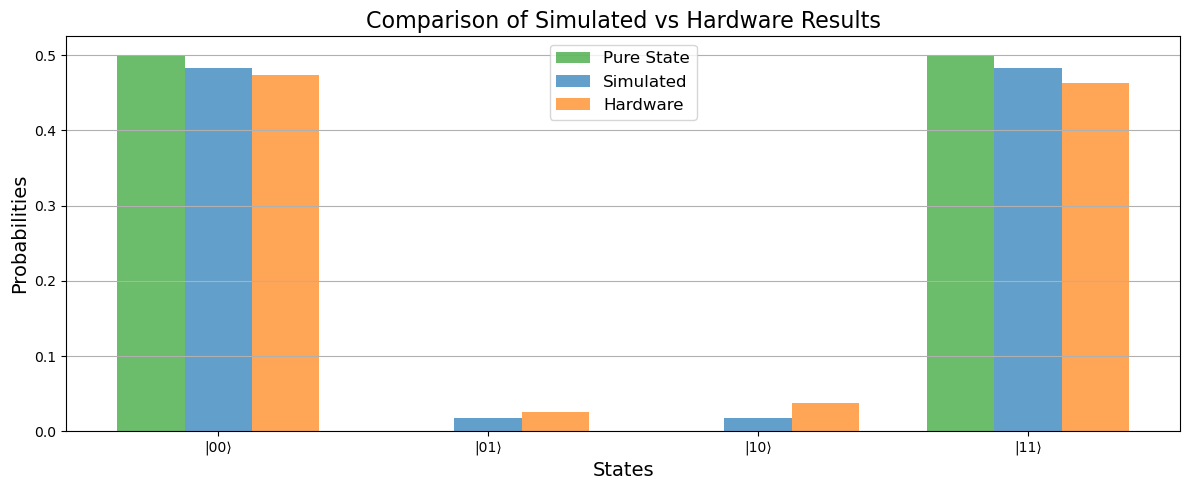

In [ ]:
plt.figure(figsize=(12, 5))
x_labels = [f"|{i}{j}\u27E9" for i in range(2) for j in range(2)]
indices = list(range(len(x_labels)))
bar_width = 0.25

plt.bar([i - bar_width for i in indices], probs_pure, width=bar_width, label="Pure State", alpha=0.7, color="C2")
plt.bar(indices, probs_simulated, width=bar_width, label="Simulated", alpha=0.7, color="C0")
plt.bar([i + bar_width for i in indices], probs_hardware, width=bar_width, label="Hardware", alpha=0.7, color="C1")
plt.xticks(indices, x_labels)
plt.xlabel("States", fontsize=14)
plt.ylabel("Probabilities", fontsize=14)
plt.title("Comparison of Simulated vs Hardware Results", fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### Fidelity with the Battacharyya Coefficient

The Battacharyya Coefficient is a statistical measure of similarity between two probability distributions and is symmetrical. It is given by:
\begin{equation}
BC(p, q) = \int \sqrt{p\cdot q}
\end{equation}
and the below equation shows the calculation of the coefficient for two discrete probability distributions:
\begin{equation}
BC(p, q) = \sum_{i=1}^{N}\sqrt{p_i q_i}
\end{equation}

In [17]:
def battacharyya_coefficient(p, q):
    return sum((p_i * q_i) ** 0.5 for p_i, q_i in zip(p, q))

In [18]:
print("Fidelity between Pure State and Simulated:", battacharyya_coefficient(probs_pure, probs_simulated))
print("Fidelity between Pure State and Hardware:", battacharyya_coefficient(probs_pure, probs_hardware))
print("Fidelity between Simulated and Hardware:", battacharyya_coefficient(probs_simulated, probs_hardware))

Fidelity between Pure State and Simulated: 0.9822733301015032
Fidelity between Pure State and Hardware: 0.9677254943980649
Fidelity between Simulated and Hardware: 0.9975605141502137


This discrepency between the loss of fidelity between the noise aware simulation and the hardware results is mainly due to these three main reasons:
* The results from the hardware are run on a finite number of shots, hence have a fixed precision and accuracy depending on the number of shots.
* The noise model used from the hardware is a static snapshot of the device and there can be a slight drift in the noise after a certain period of time.
* The simulation result is also an approximation of the density matrix results and these results improve as the number of trajectories increases.

## Shutdown

In [20]:
circuit.shutdown()